In [1]:
import sys
!{sys.executable} -m pip install keras pandas numpy image matplotlib scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator , load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./data2"))

Using TensorFlow backend.


['test', 'train']


In [4]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [8]:
filenames = os.listdir("./data2/train")

categories=[]
for filename in filenames:
    category=filename.split(' ')[0]
    if category =='Tomato_healthy':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {'filename':filenames,
    'category':categories}
)        

In [9]:
df.head()

,filename,category
0,Tomato_healthy (1).JPG,1
1,Tomato_healthy (10).JPG,1
2,Tomato_healthy (100).JPG,1
3,Tomato_healthy (1000).JPG,1
4,Tomato_healthy (1001).JPG,1


In [10]:
df.tail()

,filename,category
4398,Tomato_Spider (2656).JPG,0
4399,Tomato_Spider (2657).JPG,0
4400,Tomato_Spider (2658).JPG,0
4401,Tomato_Spider (2659).JPG,0
4402,Tomato_Spider (266).JPG,0


<AxesSubplot:>

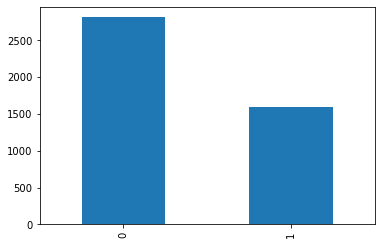

In [11]:
df['category'].value_counts().plot.bar()

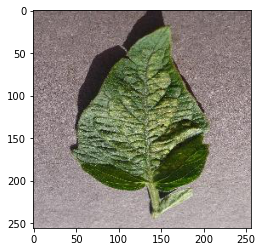

In [12]:
sample = random.choice(filenames)
image = load_img("./data2/train/"+sample)
plt.imshow(image)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy' , optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
____

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator

In [15]:
earlystop = EarlyStopping(patience=10)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5,min_lr=0.00001)

In [17]:
callbacks = [earlystop, learning_rate_reduction]

In [18]:
df["category"] = df["category"].replace({0: 'virus', 1: 'healthy'})

In [19]:
train_df , validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

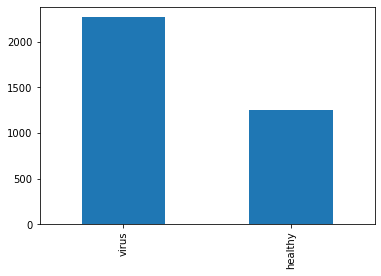

In [20]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

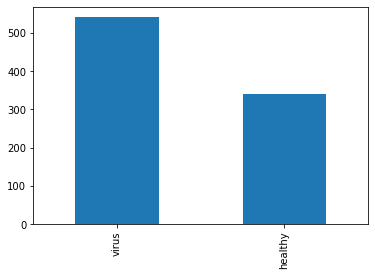

In [21]:
validate_df['category'].value_counts().plot.bar()

In [22]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./data2/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3522 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./data2/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 881 validated image filenames belonging to 2 classes.


In [25]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
example_df,
"./data2/train/",
x_col='filename',
y_col = 'category',
target_size = IMAGE_SIZE,
class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


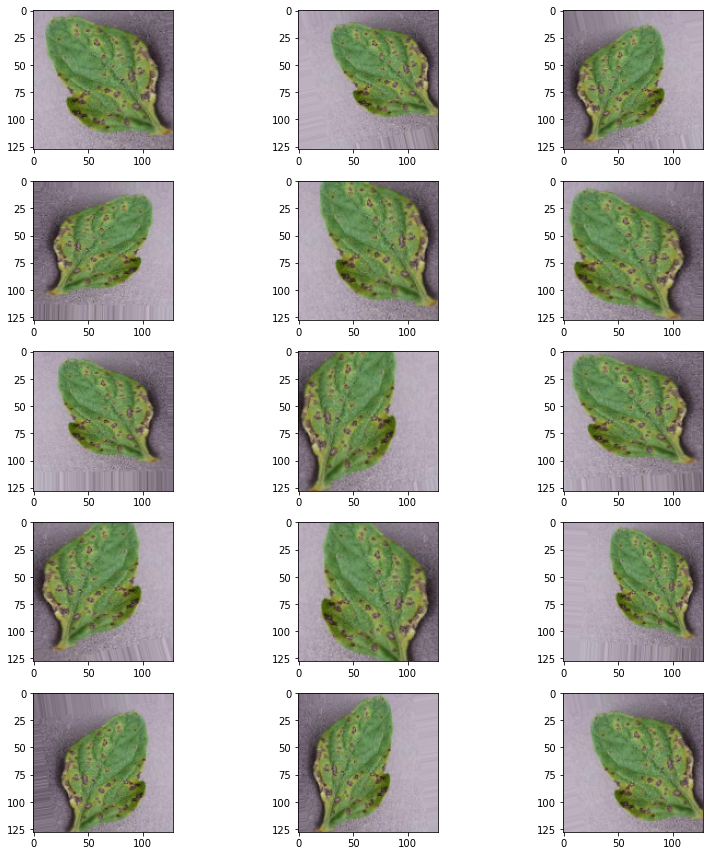

In [26]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
234/234 [==============================] - 271s 1s/step - loss: 0.1276 - acc: 0.9612 - val_loss: 3.3119 - val_acc: 0.6230
Epoch 2/50
234/234 [==============================] - 257s 1s/step - loss: 0.1047 - acc: 0.9635 - val_loss: 5.8034 - val_acc: 0.4448
Epoch 3/50
234/234 [==============================] - 257s 1s/step - loss: 0.1084 - acc: 0.9661 - val_loss: 1.3478 - val_acc: 0.7322
Epoch 4/50
234/234 [==============================] - 256s 1s/step - loss: 0.0873 - acc: 0.9752 - val_loss: 0.5759 - val_acc: 0.8529
Epoch 5/50
234/234 [==============================] - 255s 1s/step - loss: 0.0785 - acc: 0.9758 - val_loss: 1.7355 - val_acc: 0.7138
Epoch 6/50
233/234 [============================>.] - ETA: 1s - loss: 0.0661 - acc: 0.9805
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
234/234 [==============================] - 255s 1s/step - loss: 0.0664 - acc: 0.9803 - val_loss: 3.9705 - val_acc: 0.5299
Epoch 7/50
234/234 [======================

In [28]:
model.save_weights("model.h5")

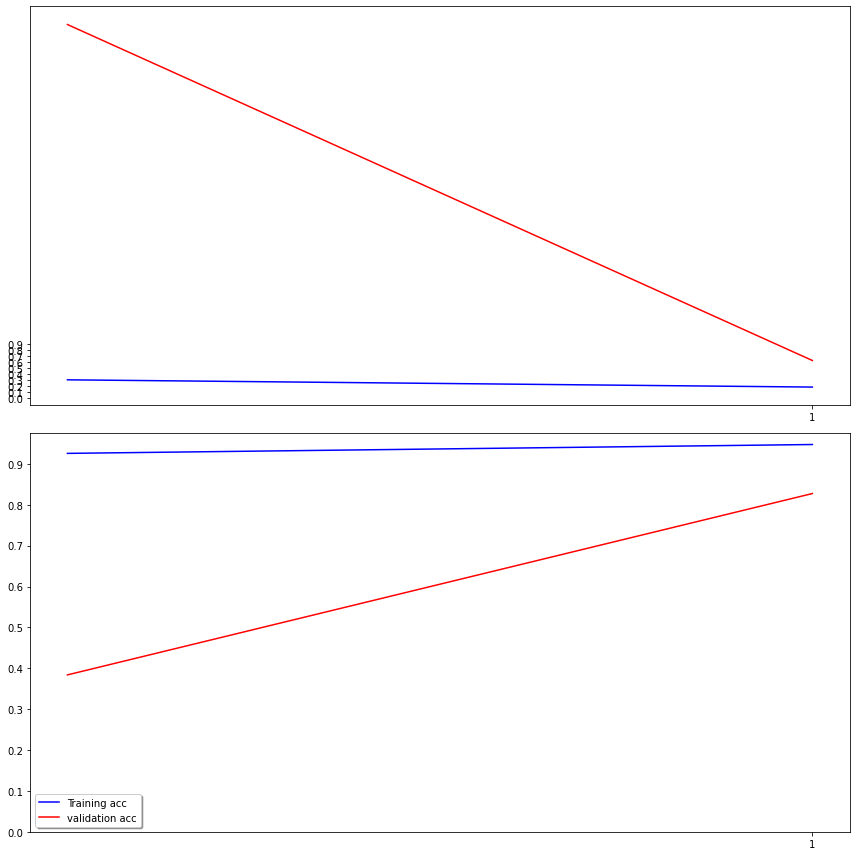

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training acc")
ax2.plot(history.history['val_acc'], color='r', label="validation acc")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [30]:
test_filenames = os.listdir("./data2/test")
test_df = pd.DataFrame({
    'filename' : test_filenames
})
nb_samples = test_df.shape[0]

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "./data2/test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 33 validated image filenames.


In [32]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [33]:
test_df['category'] = np.argmax(predict, axis=-1)

<AxesSubplot:>

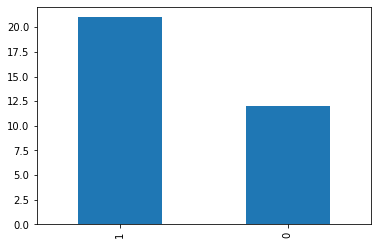

In [34]:
test_df['category'].value_counts().plot.bar()

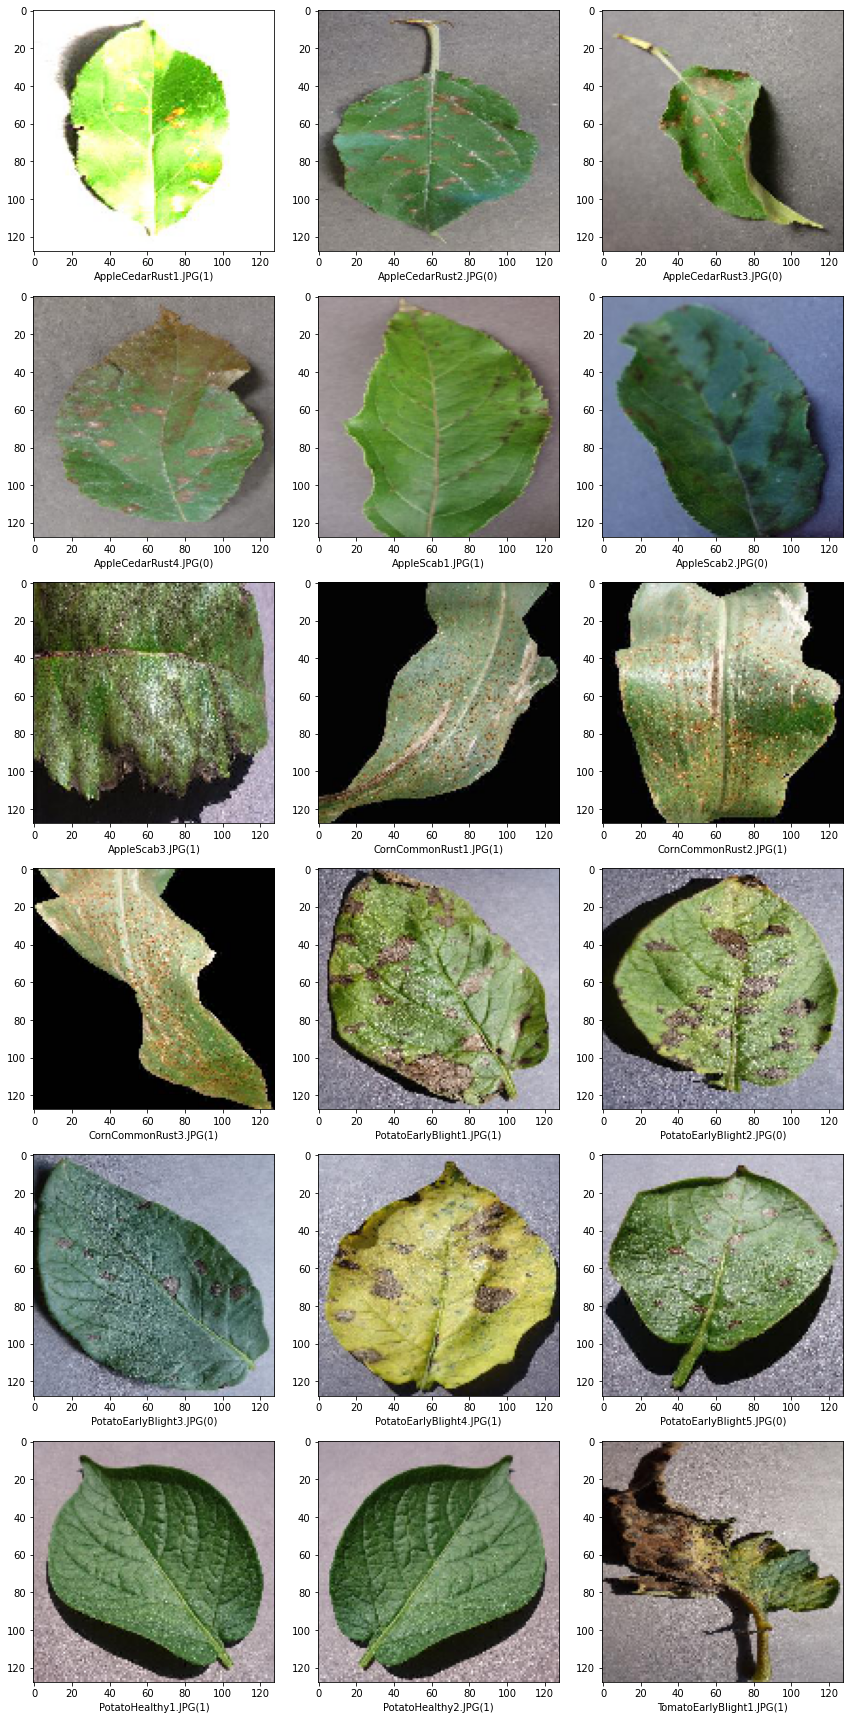

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./data2/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) +')')
plt.tight_layout()
plt.show()